In [1]:
import json
import os
import mimetypes

import pandas as pd

from plot_from_dict import plot_from_dict

C:\Users\Florent\AppData\Local\Temp\ipykernel_14484\1642169665.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
%cd ..
%pwd

c:\Users\Florent\GNN\ML_research_seminar


c:\Users\Florent\anaconda3\envs\testenc\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'c:\\Users\\Florent\\GNN\\ML_research_seminar'

In [4]:
list_dict = []

path_results = "./model/results/"

with os.scandir(path_results) as entries:

    for entry in entries:

        if entry.is_file() :

          name = entry.name

          if 'json' in mimetypes.guess_type(name)[0] :

            with open(f"{path_results}/{name}", 'r') as file:

              data = json.load(file)

            list_dict.append(data)

In [5]:
path_homophily = "./homophily/homophily_data.csv"

df_homophily = pd.read_csv(path_homophily)
df_homophily['Name_Dataset'] = df_homophily['Name_Dataset'].apply(lambda s : s.upper())
df_homophily.head()

,Name_Dataset,Seed,Homophily_edge_train,Homophily_edge_test,Homophily_node_train,Homophily_node_test,Homophily_edge_insensitive_train,Homophily_edge_insensitive_test
0,MUTAG,12345,0.721,0.722,0.661,0.662,0.034,0.035
1,ENZYMES,12345,0.667,0.660,0.665,0.664,0.370,0.399
2,PROTEINS,12345,0.657,0.654,0.652,0.648,0.372,0.367
3,PATTERN,12345,0.333,0.333,0.333,0.333,0.000,0.000
4,CLUSTER,12345,0.905,0.905,0.901,0.901,0.009,0.000


In [6]:
for dic in list_dict :
  name_dataset = dic["dataset"]
  dic["homophily"] = df_homophily.loc[df_homophily['Name_Dataset'] == name_dataset, 'Homophily_edge_train'].values[0]

FileNotFoundError: [Errno 2] No such file or directory: './results/scatter_plot_3D-MUTAG.png'

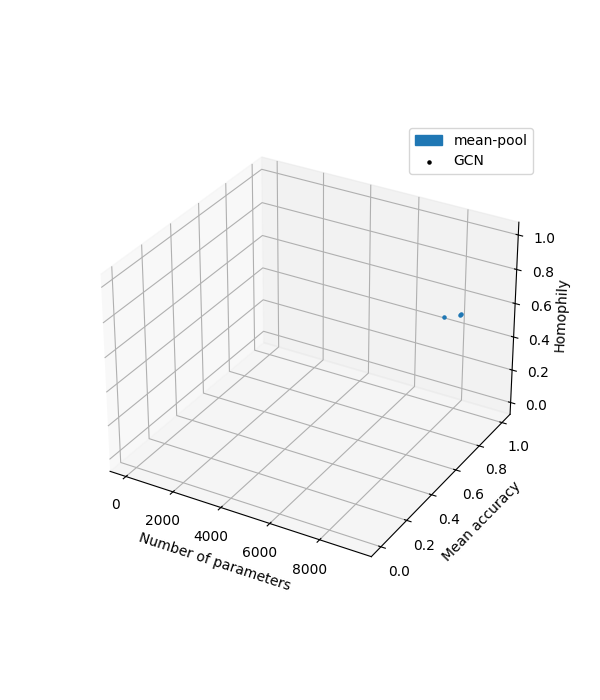

In [7]:
%matplotlib widget
plot_from_dict(list_dict, (6,7))

In [8]:
%pwd

'c:\\Users\\Florent\\GNN\\ML_research_seminar'